In [1]:
# This cell is added by sphinx-gallery
# It can be customized to whatever you like
%matplotlib inline
%pip install pennylane

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 8.2 MB/s 
     |████████████████████████████████| 13.7 MB 49.3 MB/s 
     |████████████████████████████████| 120 kB 39.2 MB/s 
     |████████████████████████████████| 1.9 MB 46.1 MB/s 


In [2]:
import pennylane as qml
from pennylane import numpy as np
from pennylane import AdamOptimizer

In [3]:
import matplotlib.pyplot as plt
import pandas as pd

# unused but required import for doing 3d projections with matplotlib < 3.2
import mpl_toolkits.mplot3d  # noqa: F401

import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import NesterovMomentumOptimizer

from sklearn import datasets

# load iris dataset
iris = datasets.load_iris()
# Since this is a bunch, create a dataframe
iris_df=pd.DataFrame(iris.data)
iris_df['class']=iris.target

iris_df.columns=['sepal_len', 'sepal_wid', 'petal_len', 'petal_wid', 'class']
iris_df = iris_df[iris_df['class'] != 2]
iris_df.loc[iris_df["class"] == 0, "class"] = 2
iris_df.loc[iris_df["class"] == 1, "class"] = -1
iris_df.loc[iris_df["class"] == 2, "class"] = 1

Y = iris_df['class']
X= iris_df.drop(columns=['class'])
X= X.to_numpy()
Y = Y.to_numpy()
normalization = np.sqrt(np.sum(X ** 2, -1))
X_norm = (X.T / normalization).T
print("First X sample (normalized):", X_norm[0])

# angles for state preparation are new features
# features = np.array([get_angles(x) for x in X_norm], requires_grad=False)
# print("First features sample      :", features[0])
features = X
np.random.seed(0)
num_data = len(Y)
num_train = int(0.75 * num_data)
index = np.random.permutation(range(num_data))
feats_train = features[index[:num_train]]
Y_train = Y[index[:num_train]]
feats_val = features[index[num_train:]]
Y_val = Y[index[num_train:]]

# We need these later for plotting
X_train = X[index[:num_train]]
X_val = X[index[num_train:]]
X_train.shape
Y_train.shape

First X sample (normalized): [0.80377277 0.55160877 0.22064351 0.0315205 ]


(75,)

In [4]:
def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2

    loss = loss / len(labels)
    return loss

def accuracy(labels, predictions):

    loss = 0
    for l, p in zip(labels, predictions):
        if abs(l - p) < 1e-5:
            loss = loss + 1
    loss = loss / len(labels)

    return loss

def cost(weights, bias, X, Y):
    predictions = [variational_classifier(weights, bias, x) for x in X]
    return square_loss(Y, predictions)


In [5]:
dev = qml.device("default.qubit", wires=2)

In [6]:
def statepreparation(a):
  qml.templates.embeddings.AmplitudeEmbedding(a, wires=list(range(2)), normalize=True)


In [13]:
def layer(W):
    qml.Rot(W[0, 0], W[0, 1], W[0, 2], wires=0)
    qml.Rot(W[1, 0], W[1, 1], W[1, 2], wires=1)
    qml.CNOT(wires=[0, 1])

In [14]:
@qml.qnode(dev)
def circuit(weights, angles):
    statepreparation(angles)

    for W in weights:
        layer(W)

    return qml.expval(qml.PauliZ(0))


def variational_classifier(weights, bias, angles):
    return circuit(weights, angles) + bias


def cost(weights, bias, features, labels):
    predictions = [variational_classifier(weights, bias, f) for f in features]
    return square_loss(labels, predictions)


In [15]:
num_qubits = 2
num_layers = 6

weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True)
bias_init = np.array(0.0, requires_grad=True)

opt = qml.AdamOptimizer()
batch_size = 5

# train the variational classifier
weights = weights_init
bias = bias_init
graph = pd.DataFrame( columns = ["iter", "cost","acc_train", "acc_val"] )
for it in range(15):

    # Update the weights by one optimizer step
    batch_index = np.random.randint(0, num_train, (batch_size,))
    feats_train_batch = feats_train[batch_index]
    Y_train_batch = Y_train[batch_index]
    weights, bias, _, _ = opt.step(cost, weights, bias, feats_train_batch, Y_train_batch)

    # Compute predictions on train and validation set
    predictions_train = [np.sign(variational_classifier(weights, bias, f)) for f in feats_train]
    predictions_val = [np.sign(variational_classifier(weights, bias, f)) for f in feats_val]

    # Compute accuracy on train and validation set
    acc_train = accuracy(Y_train, predictions_train)
    acc_val = accuracy(Y_val, predictions_val)
    graph = graph.append({'iter' : it + 1, 'cost' : cost(weights, bias, features, Y),'acc_train':acc_train,'acc_val':acc_val}, ignore_index=True)
    print(
        "Iter: {:5d} | Cost: {:0.7f} | Acc train: {:0.7f} | Acc validation: {:0.7f} "
        "".format(it + 1, cost(weights, bias, features, Y), acc_train, acc_val)
    )

Iter:     1 | Cost: 0.8654673 | Acc train: 0.5200000 | Acc validation: 0.4400000 
Iter:     2 | Cost: 0.8069873 | Acc train: 0.5200000 | Acc validation: 0.4400000 
Iter:     3 | Cost: 0.7561949 | Acc train: 0.5200000 | Acc validation: 0.4400000 
Iter:     4 | Cost: 0.7023231 | Acc train: 0.5200000 | Acc validation: 0.4800000 
Iter:     5 | Cost: 0.6493567 | Acc train: 0.5333333 | Acc validation: 0.5200000 
Iter:     6 | Cost: 0.6018348 | Acc train: 0.6400000 | Acc validation: 0.6000000 
Iter:     7 | Cost: 0.5608154 | Acc train: 0.8000000 | Acc validation: 0.7600000 
Iter:     8 | Cost: 0.5258248 | Acc train: 0.9466667 | Acc validation: 0.9200000 
Iter:     9 | Cost: 0.5006828 | Acc train: 0.9733333 | Acc validation: 1.0000000 
Iter:    10 | Cost: 0.4832625 | Acc train: 1.0000000 | Acc validation: 1.0000000 
Iter:    11 | Cost: 0.4673184 | Acc train: 1.0000000 | Acc validation: 1.0000000 
Iter:    12 | Cost: 0.4556737 | Acc train: 1.0000000 | Acc validation: 1.0000000 
Iter:    13 | Co

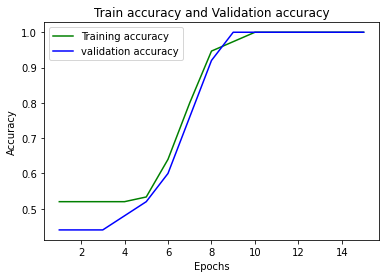

In [16]:
# graph cost vs 

acc_train = graph['acc_train']
acc_val = graph['acc_val']
epochs = graph['iter']
plt.plot(epochs, acc_train, 'g', label='Training accuracy')
plt.plot(epochs, acc_val, 'b', label='validation accuracy')
plt.title('Train accuracy and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

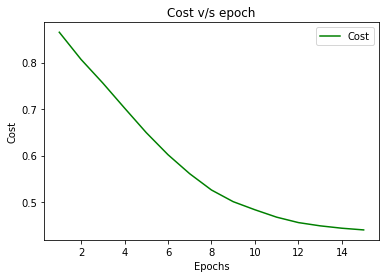

In [17]:
# graph cost vs 

cost = graph['cost']

epochs = graph['iter']
plt.plot(epochs, cost, 'g', label='Cost')
plt.title('Cost v/s epoch')
plt.xlabel('Epochs')
plt.ylabel('Cost')
plt.legend()
plt.show()